In [1]:
import time
start_time=time.time()

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import lmfit
from scipy import interpolate
import pickle

from bfunc import bfunc03s

Data load and region parameters

In [3]:
name = 'CarC'

In [4]:
reg = 'Carina'

In [5]:
pickle_in = open('SFresults//' + name + '.pkl',"rb")
SFresults = pickle.load(pickle_in)

In [6]:
B = SFresults['b2']
r = SFresults['s']
s0 = SFresults['s0']     
m = SFresults['m'] 
sig2 = SFresults['sig2'] 
r0 = SFresults['r0'] 
noise = 2.0

In [7]:
sig2,r0,m,s0

(17.88722171455478, 0.4910959902415998, 0.9, 0.009293878266869804)

In [8]:
model02 = lmfit.Model(bfunc03s)
model02.param_names

['r0', 'sig2', 'm', 's0', 'noise']

In [9]:
relative_uncertainty = 0.11
weights = 1.0 / (relative_uncertainty * B)
weights[r > r0] /= 1.3

In [10]:
for p in model02.param_names:
    model02.set_param_hint(p, min=0.0)
#model02.set_param_hint("sig2", value=sig2, vary=False)
#model02.set_param_hint("s0", min=0.2)
model02.print_param_hints()

Name      Value      Min      Max     Vary    Expr    
m           nan        0      inf     True    
noise       nan        0      inf     True    
r0          nan        0      inf     True    
s0          nan        0      inf     True    
sig2        nan        0      inf     True    


In [11]:
result2 = model02.fit(
    B, 
    weights=weights,
    r = r, r0 = r0, m = m, s0 = s0, noise = noise, sig2=sig2,
)

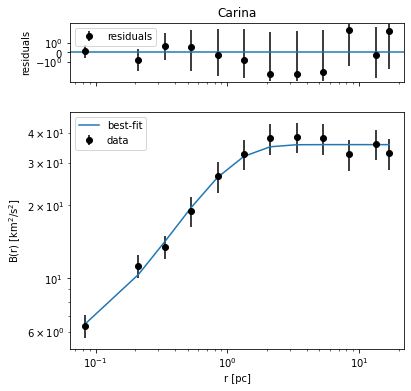

In [12]:
fig, _ = result2.plot( 'ko')
fig.axes[0].set(
    title=reg,
    xscale="log",
    yscale="symlog",
)
fig.axes[1].set(
    xscale = "log",
    yscale = "log",
    xlabel = "r [pc]",
    ylabel = r"B(r) [km$^{2}$/s$^{2}$]",
);

plt.savefig('Imgs//SF//' + reg + '.pdf', bbox_inches='tight')



In [13]:
CIresults = {'resultCI' : result2,
            'Rmax/r0' : r.max()/result2.params['r0'].value,
            'lT' : (r[3]/2**0.5)*((result2.params['r0'].value/r[3])**(result2.params['m'].value/2))
          }

In [14]:
f = open('CIresults//' + name +'.pkl',"wb")
pickle.dump(CIresults,f)
f.close()

In [15]:
print(result2.fit_report())

[[Model]]
    Model(bfunc03s)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 56
    # data points      = 12
    # variables        = 5
    chi-square         = 2.34231995
    reduced chi-square = 0.33461714
    Akaike info crit   = -9.60517735
    Bayesian info crit = -7.18064410
[[Variables]]
    r0:     0.55142895 +/- 0.20234931 (36.70%) (init = 0.491096)
    sig2:   15.5295291 +/- 21.3746742 (137.64%) (init = 17.88722)
    m:      1.25928253 +/- 1.07342664 (85.24%) (init = 0.9)
    s0:     0.00350747 +/- 2.20669464 (62914.19%) (init = 0.009293878)
    noise:  4.59520430 +/- 50.0244015 (1088.62%) (init = 2)
[[Correlations]] (unreported correlations are < 0.100)
    C(s0, noise)   =  1.000
    C(sig2, noise) = -1.000
    C(sig2, s0)    = -0.999
    C(sig2, m)     = -0.986
    C(m, noise)    =  0.984
    C(m, s0)       =  0.981
    C(r0, noise)   =  0.973
    C(r0, s0)      =  0.972
    C(r0, sig2)    = -0.969
    C(r0, m)       =  0.951


In [16]:
result2.params.pretty_print()

Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
m         1.259        0      inf    1.073     True     None     None
noise     4.595        0      inf    50.02     True     None     None
r0       0.5514        0      inf   0.2023     True     None     None
s0     0.003507        0      inf    2.207     True     None     None
sig2      15.53        0      inf    21.37     True     None     None


print('-------------------------------')
print('Parameter    Value       Stderr')
for name, param in result2.params.items():
    print('{:7s} {:11.5f} {:11.5f}'.format(name, param.value, param.stderr))

In [17]:
result2.params['r0'].stderr

0.20234931327888375

In [18]:
for p in result2.model.param_names:
    result2.params[p].stderr = result2.params[p].value * 0.1

In [19]:
result2.conf_interval()
print(result2.ci_report())

KeyboardInterrupt: 

In [ ]:
plt.style.use([
    "seaborn-poster",
])

In [ ]:
plot_limits = {
    "s0": [0.002, 0.006],
    "m": [0.7, 1.3],
    "r0": [0.3, 0.6],
    "noise": [4.0, 6.0],
}

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

#plt.title('M8')
levels = [0.6827, 0.9545, 0.9973]
colors = ["g", "y", "r"]

for ax, [xvar, yvar] in zip(axes.flat, [
    ["s0", "noise"],
    ["r0", "m"],
    ["m", "s0"],
    ["r0", "s0"],
]):
    cx, cy, grid = lmfit.conf_interval2d(
        result2, result2, xvar, yvar, 10, 10,
        limits=[plot_limits[xvar], plot_limits[yvar]],
    )
    ctp = ax.contour(cx, cy, grid, levels, colors=colors)
    ax.set_xlabel(xvar)
    ax.set_ylabel(yvar)

fig.tight_layout();

In [ ]:
print("--- %s seconds ---" % (time.time()-start_time))